In [2]:
import sys
sys.path.append('/home/lenovo/code/TreeSeg/notebooks/')
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import rasterio.warp             # Reproect raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)
tf.config.list_physical_devices('GPU')
# from configx import Preprocessing_prediction
# config = Preprocessing_prediction.Configuration(folder="full_area3")


2022-11-15 18:46:01.436684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:46:01.502802: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-15 18:46:01.519754: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 18:46:01.910426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0


2022-11-15 18:46:02.776852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:46:02.793473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:46:02.793569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:

# Define the model and compile it
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'
model_path = "/home/lenovo/code/TreeSeg/notebooks/saved_models/UNet/model-1115.h5"
model = load_model(model_path, custom_objects={'tversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity}, compile=False)

2022-11-15 18:46:02.850185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:46:02.851316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:46:02.851458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:46:02.851516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [4]:
def read_method(method:str=''):
    if method == 'Image' or method == '':
        return Image.open
    if method == 'rasterio':
        return rasterio.open
    if method == 'numpy':
        return np.load

1/1 [==============================] - 0s 10ms/step
p shape: (1, 256, 256, 3)
(1, 256, 256, 1)
[0. 1.]


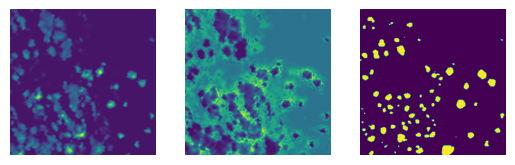

In [13]:

write_dir="/home/lenovo/treeseg-dataset/predictions/model1115"
dataset_dir = "/home/lenovo/treeseg-dataset/full_process/sample_128"

areas = [130]
rows = [2]
cols = [1]
for a in areas:
    for r in rows:
        for c in cols:
            ndvi_img= read_method()(f"{dataset_dir}/pan-0-area{a}-r{r}c{c}.png").resize((256,256))
            pan_img= read_method()(f"{dataset_dir}/ndvi-0-area{a}-r{r}c{c}.png").resize((256,256))

            comb_img = np.stack((ndvi_img, pan_img), axis=0)
            comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
            comb_img = comb_img[np.newaxis,:]
            prediction = model.predict(comb_img, steps=1)
            prediction[prediction>0.5]=1
            prediction[prediction<=0.5]=0
            
            p=np.concatenate((comb_img , prediction), axis = -1)
            print(f"p shape: {p.shape}") # (1,256,256,3)
            print(prediction.shape) # (1,256,256,1)
            print(np.unique(prediction))
            display_images(p,titles=None, interpolation=None, save=True, dir=f"{write_dir}/area{a}-c{r}r{c}")